The Ulitmate Fighter Championship (UFC) is an America Mixed Martial Arts promotion at the frontier of the sport. Since 1993, The UFC has hosted over 500 events, each of which has up to 20 fights. The fights are made and announced by matchemakers and the fighters who are all members of the UFC roster. In the roster there are 8 weight classes for men and 4 weight classes for women, each weight class consisting of approximately 50 fighters. Fighters signed to the UFC typically have made a name for themselves in other combat sports or are elite prospects from smaller or regional MMA promotions, so the UFC has been able to boast the best of the best during its existance.

On a given fight night, the fights are made of about 5 fights on the undercard and 5 fights on the main card. The undercard typically consists of new signees and low ranked fights while the main card will include 3-4 mid-ranked fighters with 1-2 high profile bouts, also known as the main event. There is no restriction on which weight class must have a fight on card. Each of the fights consist of three 5 minute rounds (execpt the main event, which has five rounds) where the fight will continue until time runs out and the fight is determined by a decsion by judges or the ref determines that one fighter has ceased to inteligently defend themselves. The ref's decsion can come from several different situations incuding a submission, knockout, or technical knockout.



In [1]:
# Necessary libraries and imports to complete this tutorial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import datetime 
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("data.csv")

Fighters are represented by red and blue, by the color of their corners. In general, the red cornor is assigned to the side more notable and thus more favored to win. This is also observed in how the blue cornor, by custom, always walks out first. In title bouts, the current champion is always red and walks out second. Each row is a compilation of both fighter stats up to the the current fight. The columns contain complied average stats of all the fights previously. 
*** ADD INFO ON COLUMN LABEL DESCRIPTION ***
The data consists of logistics about the fight and data specific to each fighter. The data pertaining to the red fighter is prefixed with 'R_' and for the blue fighter 'B_'. The 'opp_' tag indicates data done by the opponent on the fighter. The target variable is 'Winner' which is the only column that tells you the outcome of the fight.

Since there are well over 100 columns of data, we will select a sample of the columns to explore. 

# TIDYING AND SELECTING DATA

Immediatly, we can see that depending on the cricumstances of the fight, red fighters have been favored over the years. Though this isn't a completely reliable metric in predicting fights, there is a variance in the favoring when adjusting the fight logistics. There are three types of fights: Title fights (always 5 rounds), 5 round non-title fights, and 3 round fights (always non-title). There are 5144 fights in the data set and the the five round fights make up 502 of them. The variance in red favoring is distinct in each of these three fight categories:

In [24]:
title_df = data.loc[data['title_bout'] == True]
non_title_df = data.loc[(data['title_bout'] == False)]

print('The number of title fights: ', title_df.shape[0])
print('The number of non-title fights: ', non_title_df.shape[0])

print('Probability red fighter wins in title fight: ', title_df[title_df['Winner'] == 'Red'].shape[0]/title_df.shape[0])
print('Probability red fighter wins in a non-title fight: ', non_title_df[non_title_df['Winner'] == 'Red'].shape[0]/non_title_df.shape[0])


The number of title fights:  335
The number of non-title fights:  4809
Probability red fighter wins in title fight:  0.8029850746268656
Probability red fighter wins in a non-title fight:  0.6656269494697442


Since the data is averaged based on each fight, it is important to include the statstics of the opponent ('opp') historical data since not all fights are the same length. The data includes many columns specifying types of attacks landed and attempted and is seperated in to grappling and striking sections. The striking data has averages Body, Clinch, Distance, Ground, Head, Leg, Knockdowns, and Significant Strikes and grappling data for Pass, Reverasals, Submissions, and Takedowns. A visual representation of some of these can be found here: https://www.theguardian.com/sport/ng-interactive/2016/jul/09/mixed-martial-arts-fighting-techniques-guide-ufc#:~:text=Boxing%2C%20Kickboxing%20and%20Muay%20Thai,and%20legs%20to%20throw%20strikes.

To arrange the data, we will seperate the specific types of attacks from the totals. For matters of a different perspective, we will also create a dataframe that includes non-fight related metrics such as age, height, reach, stance, etc. Lastly, we will create two more dataframes storing the specifcs of the striking and grappling data.

In [4]:
metrics_df = data[['R_fighter','B_fighter','Winner','B_Stance','B_Height_cms','B_Reach_cms','B_age','B_wins','B_losses','R_Stance','R_Height_cms','R_Reach_cms','R_age','R_wins','R_losses']]
#metrics_df.head()   

In [5]:
totals_df = data[['R_fighter','B_fighter','weight_class','Winner','R_avg_TOTAL_STR_att','R_avg_TOTAL_STR_landed','R_avg_opp_TOTAL_STR_att','R_avg_opp_TOTAL_STR_landed','B_avg_TOTAL_STR_att','B_avg_TOTAL_STR_landed','B_avg_opp_TOTAL_STR_att','B_avg_opp_TOTAL_STR_landed']]
#totals_df.head()

In [6]:
grappling_df = data[['R_fighter','B_fighter','weight_class','Winner','R_avg_PASS','R_avg_REV','R_avg_SUB_ATT','R_avg_TD_att','R_avg_TD_landed','R_avg_TD_pct','B_avg_PASS','B_avg_REV','B_avg_SUB_ATT','B_avg_TD_att','B_avg_TD_landed','B_avg_TD_pct']]
opp_grappling_df = data[['R_fighter','B_fighter','weight_class','Winner','R_avg_opp_PASS','R_avg_opp_REV','R_avg_opp_SUB_ATT','R_avg_opp_TD_att','R_avg_opp_TD_landed','R_avg_opp_TD_pct','B_avg_opp_PASS','B_avg_opp_REV','B_avg_opp_SUB_ATT','B_avg_opp_TD_att','B_avg_opp_TD_landed','B_avg_opp_TD_pct']]

#grappling_df.head()

In [7]:
striking_df = data[['R_fighter','B_fighter','weight_class','Winner','R_avg_BODY_att','R_avg_BODY_landed','R_avg_CLINCH_att','R_avg_CLINCH_landed','R_avg_DISTANCE_att','R_avg_DISTANCE_landed','R_avg_GROUND_att','R_avg_GROUND_landed','R_avg_HEAD_att','R_avg_HEAD_landed','R_avg_LEG_att','R_avg_LEG_landed','R_avg_KD','B_avg_BODY_att','B_avg_BODY_landed','B_avg_CLINCH_att','B_avg_CLINCH_landed','B_avg_DISTANCE_att','B_avg_DISTANCE_landed','B_avg_GROUND_att','B_avg_GROUND_landed','B_avg_HEAD_att','B_avg_HEAD_landed','B_avg_LEG_att','B_avg_LEG_landed','B_avg_KD']]
opp_striking_df = data[['R_fighter','B_fighter','weight_class','Winner','R_avg_opp_BODY_att','R_avg_opp_BODY_landed','R_avg_opp_CLINCH_att','R_avg_opp_CLINCH_landed','R_avg_opp_DISTANCE_att','R_avg_opp_DISTANCE_landed','R_avg_opp_GROUND_att','R_avg_opp_GROUND_landed','R_avg_opp_HEAD_att','R_avg_opp_HEAD_landed','R_avg_opp_LEG_att','R_avg_opp_LEG_landed','R_avg_opp_KD','B_avg_opp_BODY_att','B_avg_opp_BODY_landed','B_avg_opp_CLINCH_att','B_avg_opp_CLINCH_landed','B_avg_opp_DISTANCE_att','B_avg_opp_DISTANCE_landed','B_avg_opp_GROUND_att','B_avg_opp_GROUND_landed','B_avg_opp_HEAD_att','B_avg_opp_HEAD_landed','B_avg_opp_LEG_att','B_avg_opp_LEG_landed','B_avg_opp_KD']]

#striking_df.head()

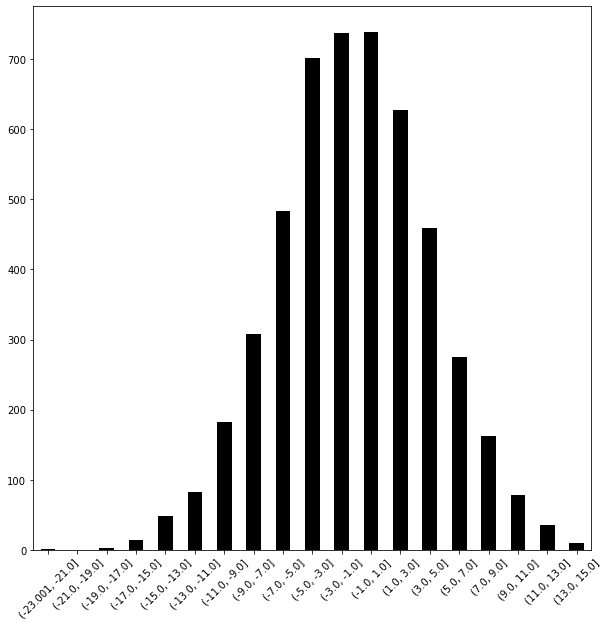

In [8]:
# observe win distributions in reach and age differences

age_diff = pd.Series(name='age_diff', dtype='float64')
reach_diff = pd.Series(name='age_diff', dtype='float64')
for row_index,row in metrics_df.iterrows():
    a = row['R_age'] - row['B_age']
    r = row['R_Reach_cms'] - row['B_Reach_cms']
    
    if (row['Winner'] == 'Blue'):
        a = row['B_age'] - row['R_age']
        r = row['B_Reach_cms'] - row['R_Reach_cms']
    
    age_diff = age_diff.append(pd.Series(a))
    reach_diff = reach_diff.append(pd.Series(r))

age_diff_list = age_diff.tolist()
data['age_diff'] = age_diff_list

reach_diff_list = reach_diff.tolist()
data['reach_diff'] = reach_diff_list

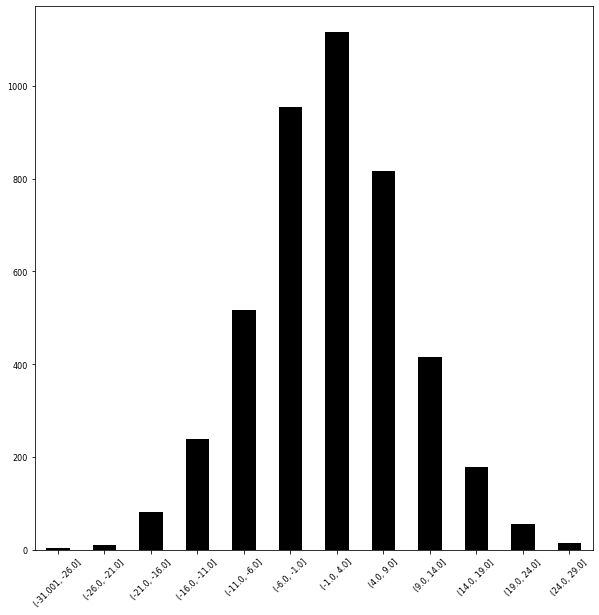

In [9]:
out = pd.cut(reach_diff, bins=list(range(-31,34,5)), include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="k", figsize=(10,10))
plt.xticks(rotation='45')
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.show()

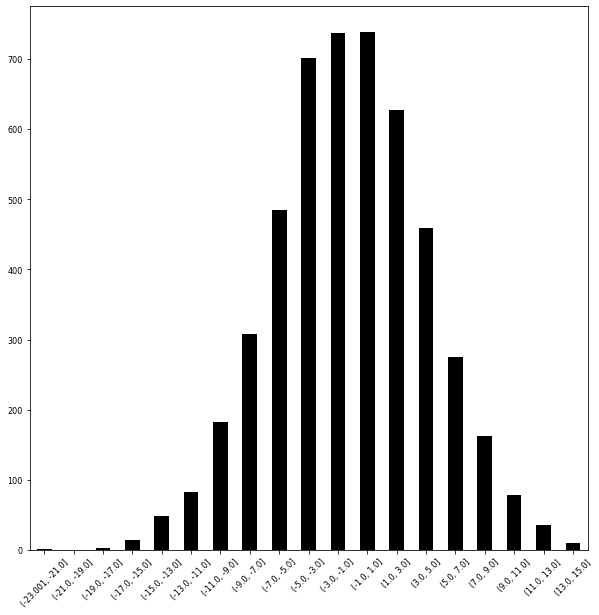

In [10]:
out = pd.cut(age_diff, bins=list(range(-23,17,2)), include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="k", figsize=(10,10))
plt.xticks(rotation='45')
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.show()

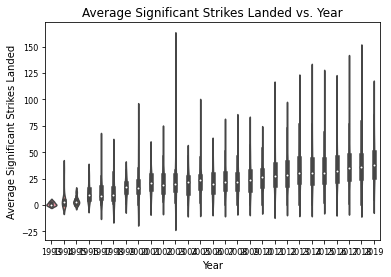

In [11]:
# Explore how striking and striking defence has changed over time.

data['date'] = pd.to_datetime(data['date'])
year_list = [i.year for i in data['date']]

fig = sns.violinplot(x=year_list, y=np.array(data['R_avg_SIG_STR_landed']))
fig.set(xlabel="Year", ylabel="Average Significant Strikes Landed", title="Average Significant Strikes Landed vs. Year");


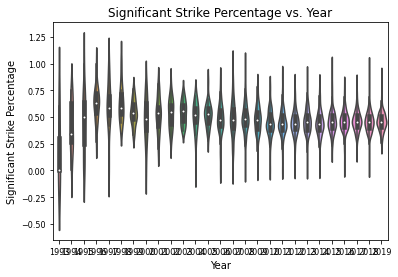

In [12]:
fig = sns.violinplot(x=year_list, y=np.array(data['R_avg_SIG_STR_pct']))
fig.set(xlabel="Year", ylabel="Significant Strike Percentage", title="Significant Strike Percentage vs. Year");

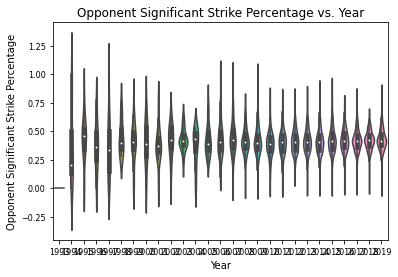

In [13]:
fig = sns.violinplot(x=year_list, y=np.array(data['R_avg_opp_SIG_STR_pct']))
fig.set(xlabel="Year", ylabel="Opponent Significant Strike Percentage", title="Opponent Significant Strike Percentage vs. Year");

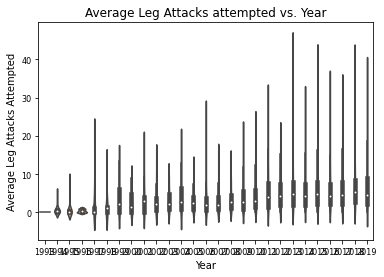

In [14]:
fig = sns.violinplot(x=year_list, y=np.array(data['R_avg_LEG_landed']))
fig.set(xlabel="Year", ylabel="Average Leg Attacks Attempted", title="Average Leg Attacks attempted vs. Year");

While the trends over the years of each statistic seem to vary by only a little year to year, there are certainly outliers that suggest some fighters were exceedingly good at certain aspects of a fight. This may be related to striking, grappling, defence, or even longevity of their career. With this in mind, the debate about who the "goat" of MMA is, is one that is everalasting and constantly evolving. The advent of new fighters, fighting styles, and champions every year, keeps the conversation fresh and makes for an interesting search into which fighters stood out in each of their respective times or through the full history of the UFC. For this analysis, we will filter the data to include only fighters who have fought atleast 10 times in the UFC and are part of the Modern era of the UFC. The cutoff for this period is from UFC 28 onward which premiered no Novermber 17, 2000. Prior to this was the Pioneer era. During this period, the UFC's rules, fighters, and publicty were still dramatically evolving which lead to some significant outliers. Also, for the purposes of this search, we will be looking into the red side fighters as they are typically the more notable fighters and if a fighter is to be considered one of the best, has likely fought most fights as the red side.

https://www.newsday.com/sports/mixed-martial-arts/ufc-hall-of-fame-1.26543626#:~:text=The%20UFC%20began%20its%20Hall,the%20Pioneer%20Era%20(before%20Nov.

In [15]:
data_filtered = data[(data['R_wins'] + data['R_losses'] >= 10) & (data['date'] > datetime.datetime(2000, 10, 17))] 

In [16]:
# Lets look at some of the top 10 fighters in each statistic.

# Here are the top 10 fighters in the striking portion of the data.
print(data_filtered.sort_values(by=['R_avg_TOTAL_STR_landed'], ascending=False)[['R_fighter','R_avg_TOTAL_STR_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_SIG_STR_landed'], ascending=False)[['R_fighter','R_avg_SIG_STR_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_KD'], ascending=False)[['R_fighter','R_avg_KD']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_BODY_landed'], ascending=False)[['R_fighter','R_avg_BODY_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_HEAD_landed'], ascending=False)[['R_fighter','R_avg_HEAD_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_DISTANCE_landed'], ascending=False)[['R_fighter','R_avg_LEG_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_LEG_landed'], ascending=False)[['R_fighter','R_avg_LEG_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))

# Here are the top 10 fighters in the grappling portion of the data.
print(data_filtered.sort_values(by=['R_avg_SUB_ATT'], ascending=False)[['R_fighter','R_avg_SUB_ATT']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['B_avg_TD_landed'], ascending=False)[['R_fighter','R_avg_TD_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_TD_pct'], ascending=False)[['R_fighter','R_avg_TD_pct']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_PASS'], ascending=False)[['R_fighter','R_avg_PASS']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['B_avg_REV'], ascending=False)[['R_fighter','B_avg_REV']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))

# Here are the top 10 fighters for career statistics.
print(data_filtered.sort_values(by=['R_total_title_bouts'], ascending=False)[['R_fighter','R_total_title_bouts']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_longest_win_streak'], ascending=False)[['R_fighter','R_longest_win_streak']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_total_rounds_fought'], ascending=False)[['R_fighter','R_total_rounds_fought']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_wins'], ascending=False)[['R_fighter','R_wins']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_total_title_bouts'], ascending=False)[['R_fighter','R_total_title_bouts']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))

# Here are the top 10 fighters in the defensive perspectives.
print(data_filtered.sort_values(by=['R_avg_opp_HEAD_landed'], ascending=True)[['R_fighter','R_avg_opp_HEAD_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_opp_DISTANCE_landed'], ascending=True)[['R_fighter','R_avg_opp_DISTANCE_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_opp_TOTAL_STR_landed'], ascending=True)[['R_fighter','R_avg_opp_TOTAL_STR_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_opp_TD_landed'], ascending=True)[['R_fighter','R_avg_opp_TD_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))
print(data_filtered.sort_values(by=['R_avg_opp_PASS'], ascending=True)[['R_fighter','R_avg_opp_PASS']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10))


               R_fighter  R_avg_TOTAL_STR_landed
425   Joanna Jedrzejczyk              131.600000
3346           Jon Fitch              131.533333
3303           Nick Diaz              121.727273
2660   Georges St-Pierre              119.900000
3056      Matthew Riddle              115.000000
3711          Sean Sherk              108.454545
1506  Demetrious Johnson              108.230769
386      Jessica Andrade              106.538462
1920       Carlos Condit              106.500000
1410      Cain Velasquez              105.692308
               R_fighter  R_avg_SIG_STR_landed
425   Joanna Jedrzejczyk            120.500000
86          Max Holloway             85.631579
386      Jessica Andrade             75.538462
1413        TJ Dillashaw             73.090909
1366         Court McGee             71.100000
1730     Fabio Maldonado             69.100000
2238  Demetrious Johnson             69.000000
591          Evan Dunham             66.444444
718          Cub Swanson             6

In [17]:
# Sorted and prepped dataframes

# Striking
d1 = data_filtered.sort_values(by=['R_avg_TOTAL_STR_landed'], ascending=False)[['R_fighter','R_avg_TOTAL_STR_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_TOTAL_STR_landed'], ascending=True).reset_index(drop=True);
d2 = data_filtered.sort_values(by=['R_avg_SIG_STR_landed'], ascending=False)[['R_fighter','R_avg_SIG_STR_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_SIG_STR_landed'], ascending=True).reset_index(drop=True);
d3 = data_filtered.sort_values(by=['R_avg_KD'], ascending=False)[['R_fighter','R_avg_KD']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_KD'], ascending=True).reset_index(drop=True);
d4 = data_filtered.sort_values(by=['R_avg_BODY_landed'], ascending=False)[['R_fighter','R_avg_BODY_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_BODY_landed'], ascending=True).reset_index(drop=True);
d5 = data_filtered.sort_values(by=['R_avg_HEAD_landed'], ascending=False)[['R_fighter','R_avg_HEAD_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_HEAD_landed'], ascending=True).reset_index(drop=True);
d6 = data_filtered.sort_values(by=['R_avg_DISTANCE_landed'], ascending=False)[['R_fighter','R_avg_DISTANCE_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_DISTANCE_landed'], ascending=True).reset_index(drop=True);
d7 = data_filtered.sort_values(by=['R_avg_LEG_landed'], ascending=False)[['R_fighter','R_avg_LEG_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(10).head(51).sort_values(by=['R_avg_LEG_landed'], ascending=True).reset_index(drop=True);

# Grappling
d8 = data_filtered.sort_values(by=['R_avg_SUB_ATT'], ascending=False)[['R_fighter','R_avg_SUB_ATT']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_SUB_ATT'], ascending=True).reset_index(drop=True);
d9 = data_filtered.sort_values(by=['B_avg_TD_landed'], ascending=False)[['R_fighter','R_avg_TD_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_TD_landed'], ascending=True).reset_index(drop=True);
d10 = data_filtered.sort_values(by=['R_avg_TD_pct'], ascending=False)[['R_fighter','R_avg_TD_pct']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_TD_pct'], ascending=True).reset_index(drop=True);
d11 = data_filtered.sort_values(by=['R_avg_PASS'], ascending=False)[['R_fighter','R_avg_PASS']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_PASS'], ascending=True).reset_index(drop=True);
d12 = data_filtered.sort_values(by=['B_avg_REV'], ascending=False)[['R_fighter','R_avg_REV']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_REV'], ascending=True).reset_index(drop=True);

# Career
d13 = data_filtered.sort_values(by=['R_total_title_bouts'], ascending=False)[['R_fighter','R_total_title_bouts']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_total_title_bouts'], ascending=True).reset_index(drop=True);
d14 = data_filtered.sort_values(by=['R_longest_win_streak'], ascending=False)[['R_fighter','R_longest_win_streak']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_longest_win_streak'], ascending=True).reset_index(drop=True);
d15 = data_filtered.sort_values(by=['R_total_rounds_fought'], ascending=False)[['R_fighter','R_total_rounds_fought']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_total_rounds_fought'], ascending=True).reset_index(drop=True);
d16 = data_filtered.sort_values(by=['R_wins'], ascending=False)[['R_fighter','R_wins']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_wins'], ascending=True).reset_index(drop=True);
d17 = data_filtered.sort_values(by=['R_total_title_bouts'], ascending=False)[['R_fighter','R_total_title_bouts']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_total_title_bouts'], ascending=True).reset_index(drop=True);

# Defensive
d18 = data_filtered.sort_values(by=['R_avg_opp_HEAD_landed'], ascending=True)[['R_fighter','R_avg_opp_HEAD_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_opp_HEAD_landed'], ascending=False).reset_index(drop=True);
d19 = data_filtered.sort_values(by=['R_avg_opp_DISTANCE_landed'], ascending=True)[['R_fighter','R_avg_opp_DISTANCE_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_opp_DISTANCE_landed'], ascending=False).reset_index(drop=True);
d20 = data_filtered.sort_values(by=['R_avg_opp_TOTAL_STR_landed'], ascending=True)[['R_fighter','R_avg_opp_TOTAL_STR_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_opp_TOTAL_STR_landed'], ascending=False).reset_index(drop=True);
d21 = data_filtered.sort_values(by=['R_avg_opp_BODY_landed'], ascending=True)[['R_fighter','R_avg_opp_BODY_landed']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_opp_BODY_landed'], ascending=False).reset_index(drop=True);
d22 = data_filtered.sort_values(by=['R_avg_opp_SIG_STR_pct'], ascending=True)[['R_fighter','R_avg_opp_SIG_STR_pct']].drop_duplicates(subset=['R_fighter'], keep='first', inplace=False).head(51).sort_values(by=['R_avg_opp_SIG_STR_pct'], ascending=False).reset_index(drop=True);


In [18]:
# Now lets sum up all the ranks of each fighter and see who stands out!

best_strikers = {}
data_sets = [d1, d2, d3, d4, d5, d6, d7]
for i,dataset in enumerate(data_sets):
    for row_index,row in dataset.iterrows():
        name = row['R_fighter']
        if name in best_striker: best_striker[name] = best_striker.get(name, 0) + row_index
        else: best_striker[name] = row_index
  
sorted(best_striker.values())     
sorted(best_striker, key=best_striker.get, reverse=True)[:10]

['Joanna Jedrzejczyk',
 'Max Holloway',
 'Jessica Andrade',
 'Fabio Maldonado',
 'Court McGee',
 'Junior Dos Santos',
 'TJ Dillashaw',
 'John Lineker',
 'Cub Swanson',
 'Frankie Edgar']

In [19]:
best_grapplers = {}
data_sets = [d8, d9, d10, d11, d12]
for i,dataset in enumerate(data_sets):
    for row_index,row in dataset.iterrows():
        name = row['R_fighter']
        if name in best_grappler: best_grappler[name] = best_grappler.get(name, 0) + row_index
        else: best_grappler[name] = row_index
  
sorted(best_grappler.values())     
sorted(best_grappler, key=best_grappler.get, reverse=True)[:10]

['Georges St-Pierre',
 'Rani Yahya',
 'Gleison Tibau',
 'Demian Maia',
 'Matt Hughes',
 'Kurt Pellegrino',
 'Jon Fitch',
 'Mark Bocek',
 'Matthew Riddle',
 'BJ Penn']

In [20]:
best_careers = {}
data_sets = [d13, d14, d15, d16, d17]
for i,dataset in enumerate(data_sets):
    for row_index,row in dataset.iterrows():
        name = row['R_fighter']
        if name in best_career: best_career[name] = best_career.get(name, 0) + row_index
        else: best_career[name] = row_index
  
sorted(best_career.values())     
sorted(best_career, key=best_career.get, reverse=True)[:10]

['Georges St-Pierre',
 'Jon Jones',
 'Demetrious Johnson',
 'Anderson Silva',
 'Randy Couture',
 'Frankie Edgar',
 'Tito Ortiz',
 'Matt Hughes',
 'Max Holloway',
 'Lyoto Machida']

In [21]:
best_defensive = {}
data_sets = [d18, d19, d20, d21, d22]
for i,dataset in enumerate(data_sets):
    for row_index,row in dataset.iterrows():
        name = row['R_fighter']
        if name in best_defensive: best_defensive[name] = best_defensive.get(name, 0) + row_index
        else: best_defensive[name] = row_index
  
sorted(best_defensive.values())     
sorted(best_defensive, key=best_defensive.get, reverse=True)[:10]


['Melvin Guillard',
 'Anderson Silva',
 'Anthony Johnson',
 'Matt Hughes',
 'Tito Ortiz',
 'Thiago Santos',
 'Andrei Arlovski',
 'Georges St-Pierre',
 'Evan Tanner',
 'Myles Jury']

In [22]:
best_overall = {}
data_sets = [d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18, d19, d20, d21, d22]
for i,dataset in enumerate(data_sets):
    for row_index,row in dataset.iterrows():
        name = row['R_fighter']
        if name in best_overall: best_overall[name] = best_overall.get(name, 0) + row_index
        else: best_overall[name] = row_index
  
sorted(best_overall.values())     
sorted(best_overall, key=best_overall.get, reverse=True)[:25]

['Georges St-Pierre',
 'Jon Jones',
 'Demetrious Johnson',
 'Anderson Silva',
 'Matt Hughes',
 'Frankie Edgar',
 'Max Holloway',
 'Tito Ortiz',
 'Joanna Jedrzejczyk',
 'Cain Velasquez',
 'Lyoto Machida',
 'Michael Bisping',
 'Randy Couture',
 'Andrei Arlovski',
 'Melvin Guillard',
 'Junior Dos Santos',
 'Chuck Liddell',
 'TJ Dillashaw',
 'Demian Maia',
 'BJ Penn',
 'Josh Koscheck',
 'Jessica Andrade',
 'Khabib Nurmagomedov',
 'Vitor Belfort',
 'Tony Ferguson']